## Homework2: Earthquake Occurrence Statistics - Omori Law

In Homework 1 we focused on the Gutenberg-Richter relationship (Gutenberg and Richter, 1949), which informs on the rate of earthquake occurrence based on seismicity catalog data. In Homework 2 we will explore Omori Law (Omori, 1894), which is used to characterize the rate at which aftershocks occur following a large mainshock event. This statistic is used for comparing the aftershock productivity of different earthquakes and regions, make forecasts of the likelihood of large damaging aftershocks and to distinguish between earthquake faulting and possibly geothermal or volcanic-related seismicity by examining whether the distribution describes a "mainshock/aftershock" pattern or is more "swarm-like". 

We will use the bay area seismicty catalog to study the aftershocks of the 1989 Loma Prieta earthquake which occurred extensive damage in the San Francisco Bay Area.

### The following three cells set up the python environment, define the useful subroutines/functions and fault data from last week. You do not need to edit these cells.

In [8]:
#Initial Setup and Subroutine Definitions - No need to edit this cell

import math
import datetime
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader as cReader
import pandas as pd
import datetime as dt

#The following are useful functions/subroutines

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two geographic points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    
    The first pair can be singular and the second an array

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371.0 * c
    return km

def parseCatalog(p):
    '''
    Function to slice an ANSS catalog loaded as a pandas dataframe and return arrays of info, including a days array
    '''
    year=p['DateTime'].dt.year
    month=p['DateTime'].dt.month
    day=p['DateTime'].dt.day
    hour=p['DateTime'].dt.month
    minute=p['DateTime'].dt.minute
    sec=p['DateTime'].dt.second
    lat=p['Latitude'].values
    lon=p['Longitude'].values
    mag=p['Magnitude'].values

    days = countDays(len(year),year,month,day)
    return year,month,day,hour,minute,sec,lat,lon,mag,days

def countDays(npts,y,m,d):
    '''
    Function to create an array of days
    '''
    days=np.zeros(npts)
    for i in range(0,npts,1):
        d0 = datetime.date(y[0], m[0], d[0])
        d1 = datetime.date(y[i], m[i], d[i])
        delta = d1 - d0
        days[i]=delta.days
    return days


In [2]:
#This function is for declustering and you do not need to edit this cell
def declustering_algorithm(cat, definition=1):
    '''
    Decluster a catalog
    
    note: This function may take a few minutes to complete
    
    calls parseCatalog()
    
    Inputs: 
    
    cat must be an anss formatted pandas datafram
    definition is the algorithm (1 - 2) from Stiphout, 2012, which determines Dtest and Ttest values
        Definition = 1 : Gardner and Knopoff, 1974 [default]
        Definition = 2 : Uhrhammer, 1986
    
    '''
    
    # do not edit
    cnt=0
    save=np.zeros((1,10000000),dtype=int)

    # grab catalog arrays
    year,month,day,hour,minute,sec,lat,lon,mag,days = parseCatalog(cat)
    ne=len(year)

    # main for-loop over events
    for i in range(0,ne,1):
        
        if definition == 1:
            
            # Definition #1 : Knopoff and Gardner, 1972
            Dtest=np.power(10,0.1238*mag[i]+0.983)
            if mag[i] >= 6.5:
                Ttest=np.power(10,0.032*mag[i]+2.7389)
            else:
                Ttest=np.power(10,0.5409*mag[i]-0.547)
  
        elif definition == 2:

            # Definition #2 : Uhrhammer, 1986
            Dtest=np.exp(-1.204+0.804*mag[i]) # SOLUTION
            Ttest=np.exp(-2.87+1.235*mag[i]) # SOLUTION

            
            
        a=days[i+1:ne]-days[i]
        m=mag[i+1:ne]
        b=haversine_np(lon[i],lat[i],lon[i+1:ne],lat[i+1:ne])

        icnt=np.count_nonzero(a <= Ttest)
        if icnt > 0:
            itime=np.array(np.nonzero(a <= Ttest)) + (i+1)
            for j in range(0,icnt,1):             
                if b[j] <= Dtest and m[j] < mag[i]:
                    save[0][cnt]=itime[0][j]
                    cnt += 1 # save contains index of aftershocks in cat

    #Note this is an array of indexes that will be used to delete events flagged 
                        #as aftershocks
    save=np.delete(np.unique(save),0)  
    
    # Filter or slice out the declustered and aftershock dataframe catalogs from the 
    # original dataframe catalog "data" using "save" above.
    cat_aftershocks = cat.iloc[np.unique(save)] 

    cat_declustered = cat.iloc[~cat.index.isin(save)]
    
    cat_aftershocks.reset_index(drop=True, inplace=True)
    cat_declustered.reset_index(drop=True, inplace=True)
    
    return cat_declustered, cat_aftershocks

In [3]:
#First read in the fault data - No need to edit this cell

a=pd.read_table('data/Hayward.txt') 
hay_lon=a['x'].values
hay_lat=a['y'].values

a=pd.read_table('data/San_Andreas.txt') 
SA_lon=a['x'].values - 0.03 #adjustment to the west
SA_lat=a['y'].values

a=pd.read_table('data/San_Gregorio.txt') 
SG_lon=a['x'].values
SG_lat=a['y'].values

a=pd.read_table('data/Calaveras.txt') 
cal_lon=a['x'].values
cal_lat=a['y'].values

a=pd.read_table('data/Hunting_Creek.txt') 
HC_lon=a['x'].values
HC_lat=a['y'].values

a=pd.read_table('data/Rodgers_Creek.txt') 
RC_lon=a['x'].values
RC_lat=a['y'].values

a=pd.read_table('data/Concord.txt') 
con_lon=a['x'].values
con_lat=a['y'].values

a=pd.read_table('data/Greenville.txt') 
grn_lon=a['x'].values
grn_lat=a['y'].values

a=pd.read_table('data/Maacama.txt') 
m_lon=a['x'].values
m_lat=a['y'].values

# Omori Law for Loma Prieta M6.9 Event (50 pts)

Here we will use the declustering algorithm to identify aftershocks of the October 18 1989 04:15am UTC (October 17 at 5:15pm PDT) M6.9 Loma Prieta earthquake. The Loma Prieta earthquake occurred in the Santa Cruz mountains approximately 80 km southwest of the Berkeley Campus. This wiki has some background information for the earthquake: https://en.wikipedia.org/wiki/1989_Loma_Prieta_earthquake

### Load the Earthquake Catalog



In [9]:
# read data

LP_catalog=pd.read_csv('data/bay_area_anss_1989_1995.csv')

LP_catalog=LP_catalog.dropna(subset=['Magnitude'])  #this drops the NaN from the Magnitude columns
LP_catalog=LP_catalog.reset_index(drop=True)

#the following function just reformats to a DateTime object format
LP_catalog['DateTime'] = pd.to_datetime(LP_catalog['DateTime'])
LP_catalog.head()

#parse catalog into arrays
year,month,day,hour,minute,sec,lat,lon,mag,days = parseCatalog(LP_catalog)
LP_catalog

,Unnamed: 0,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,0,1989-01-01 03:51:37.170,36.5928,-121.1027,0.00,1.26,Md,4,150.0,6.0,0.13,NC,1160762.0
1,1,1989-01-01 11:39:34.870,36.9583,-121.5762,5.70,1.07,Md,34,36.0,1.0,0.08,NC,129467.0
2,2,1989-01-01 21:05:18.030,37.5293,-121.6905,7.03,0.99,Md,11,80.0,4.0,0.02,NC,129474.0
3,3,1989-01-01 21:54:27.470,37.5590,-121.6760,7.38,0.85,Md,12,66.0,1.0,0.04,NC,129475.0
4,4,1989-01-01 21:57:12.240,36.6493,-121.2678,4.66,1.17,Md,21,65.0,1.0,0.04,NC,129476.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33337,33884,1995-12-31 10:40:19.650,36.9720,-121.6090,1.46,1.43,Md,22,57.0,3.0,0.09,NC,30093139.0
33338,33885,1995-12-31 14:24:13.900,37.1305,-121.5565,2.32,0.94,Md,7,147.0,4.0,0.02,NC,30093147.0
33339,33886,1995-12-31 17:25:14.840,36.7043,-121.3433,4.20,0.89,Md,12,66.0,1.0,0.01,NC,30093158.0
33340,33887,1995-12-31 17:48:38.320,36.8380,-121.4350,8.97,1.06,Md,5,258.0,6.0,0.18,NC,30093160.0


### Map the LP catalog

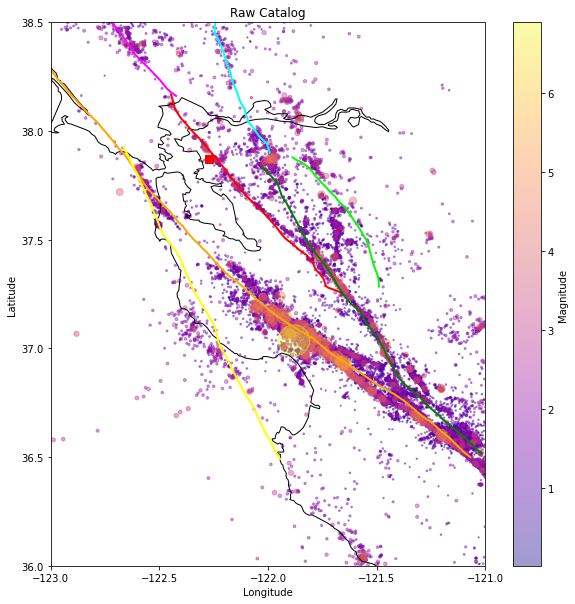

In [5]:
lat0=36.0
lat1=38.5
lon0=-123.0
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)

# coordinates for UC Berkeley
Berk_lat = 37.8716
Berk_lon = -122.2727

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=1)
ax.set_xticks(lonticks)
ax.set_yticks(latticks)
ax.set(xlabel='Longitude', ylabel='Latitude',title='Raw Catalog')

# Sort by magnitude to plot largest events on top
LP_catalog_sorted = LP_catalog.sort_values(by=['Magnitude'])
#exponent to scale marker size
z=np.exp(LP_catalog_sorted['Magnitude'])    

plt.scatter(LP_catalog_sorted['Longitude'], LP_catalog_sorted['Latitude'], s=z, 
            c=LP_catalog_sorted['Magnitude'], cmap='plasma',alpha=0.4,marker='o') # plot circles on EQs

#Plot faults and location of Berkeley
plt.plot(hay_lon,hay_lat,'-',color='red',linewidth=2,label='Hayward Fault')
plt.plot(SA_lon,SA_lat,'-',color='orange',linewidth=2,label='San Andreas Fault')
plt.plot(SG_lon,SG_lat,'-',color='yellow',linewidth=2,label='San Gregorio Fault')
plt.plot(cal_lon,cal_lat,'-',color='green',linewidth=2,label='Calaveras Fault')
plt.plot(con_lon,con_lat,'-',color='cyan',linewidth=2,label='Concord Fault')
plt.plot(grn_lon,grn_lat,'-',color='lime',linewidth=2,label='Greenville Fault')
plt.plot(m_lon,m_lat,'-',color='blueviolet',linewidth=2,label='Maacama Fault')
plt.plot(RC_lon,RC_lat,'-',color='magenta',linewidth=2,label='Rodgers Creek Fault')
plt.plot(HC_lon,HC_lat,'-',color='blue',linewidth=2,label='Hunting Creek Fault')
plt.plot(Berk_lon,Berk_lat,'rs',markersize=8,label='UC Berkeley')  # plot red square on Berkeley Campus
plt.colorbar(label='Magnitude')

plt.show()

#### Parse LP_catalog for 3 months from the earthquake & create arrays

In [10]:
#You can parse the catalog in different ways. Using boolean logic in a series of filters, or more simply making use
#of the pandas between function, e.g. dataframe.between(). The example below filters 4 months of data beginning at
#the time of the mainshock

#First lets make a deep copy of the data
LPEQ=LP_catalog.copy(deep=True)

start_date=dt.datetime(1989,10,18,0,4)
end_date=dt.datetime(1990,2,18,0,0)
LPEQ=LPEQ[LPEQ['DateTime'].between(start_date,end_date)]
LPEQ=LPEQ.reset_index(drop=True)

year,month,day,hour,minute,sec,lat,lon,mag,days = parseCatalog(LPEQ)

## Plot the Loma Preita time series


In [ ]:
# plot magnitude vs. days from mainshock


## Plot the Loma Preita Earthquake Catalog in map view


In [ ]:
#Code for LP sequence map here

## Decluster the Raw Catalog for the Loma Prieta time period

We use the same decluster algorithm previously to identify aftershocks and remove them from the 30-day Loma Preita catalog.


In [ ]:
#declustering code here
data_dec, data_after = declustering_algorithm(...,...)

# This condition should print out "True" if the catalogs were separated correctly
len(LPEQ) == len(data_after) + len(data_dec)

Create two new sets of event info arrays, one for the declustered catalog and one for the aftershock catalog.

In [ ]:
dyear,dmonth,dday,dhour,dminute,dsec,dlat,dlon,dmag,ddays = parseCatalog(data_dec)
ayear,amonth,aday,ahour,aminute,asec,alat,alon,amag,adays = parseCatalog(data_after)
dnevt =len(ddays)
anevt=len(adays)

In [ ]:
#Plot Aftershock Catalog in time series


## Plot the declustered Loma Prieta mainshock catalog in map view


In [ ]:
#Make a Map of the declustered events



## Plot the declustered Loma Prieta aftershock catalog in map view


In [ ]:
#Make a Map of Aftershock events


## Omori statistics

To compute the Omori statistics we want to bin the log10 of the number of aftershocks each day following the mainshock and fit a power law equation such as:

$$
\begin{matrix}
N=\frac{A}{(t+\epsilon)^P}, 
\end{matrix}
$$

where t is time in days, N is the number of earthquakes in the 24 hour period, and $\epsilon$ is a small number (fraction of a day) to avoid the singularity at zero time. A and P are the coeffients that we want to find through regression. This power law equation can be linearized by simply taking the log10 of both sides giving:

$$
\begin{matrix}
log_{10}(N)=a + P*log_{10}(t+\epsilon)
\end{matrix}
$$

Note: a=log10(A). Also when we regress the data, fit a line, the sign of P will be determined for us.

Note: We will use both the Gutenberg-Richter and the Omori Law statistics computed in Homework 1 in Homework 2 where we will examine the probability of earthquake occurrence and aftershock occurrence following a given mainshock.


In [ ]:
#Compute the Omori Data and plot it
epsilon=0.1
maxdays=int(np.max(adays))
t=np.arange(1,maxdays+2,1)

logt=np.log10(...)
N=np.zeros(...)

#Loop to count events for each day using np.count_nonzero()
 
logN=np.log10(...)

#Code for plot here


In [ ]:
#fit a line to the logN and logt data and then compare in N-t space
p=np.polyfit(...,...,1)
logNN=np.polyval(...,...)
NN=10**logNN

#Plot comparing the data (blue dots) and model(NN) (red line)


#Print the a and P coefficients


### Questions

- Which faults were active during Loma Prieta?

- What could cause aftershocks to occur on faults other than the mainshock fault?

- How well do the Loma Prieta aftershocks follow the Omori Power Law?

- How do the results compare using method=2 to decluster the catalog?

- How well does the estimated P value compare to the range of values given in Lay and Wallace?

#### Answers here

#### Lets use the Pre-Loma Prieta daily seismicity rate to assess when the Loma Prieta sequence aftershocks end (trend into the pre-event rate)


In [ ]:
#Make a new deep copy of the LP_catalog
PRELP=LP_catalog.copy(deep=True)

#Parse catalog having the same number of months as the LPEQ catalog
start_date=pd.datetime(...)
end_date=pd.datetime(...)
PRELP=PRELP[LP_catalog['DateTime'].between(start_date,end_date)]
PRELP=PRELP.reset_index(drop=True)

year,month,day,hour,minute,sec,lat,lon,mag,days = parseCatalog(PRELP)
PRELP

In [ ]:
#First compute the number of events per day in the PRELP catalog

#Compute the mean number of earthquakes per day
meanN=np.mean(preN)
print(f'mean pre-LP events per day {meanN:.1f}')

#Use np.where() to find the index where N is less than the pre-LP daily rate.
#Use the first value of the index array returned by np.where to determine the numbers of days elaspsed when the seismicity
#rate first returns to the pre-LP average

result=np.where(...)  #N is the LP sequence daily bins, and meanN is the average from the pre-LP catalog


### Questions

1. Based on the daily rate of earthquakes when does the Loma Prieta earthquake aftershock sequence "end?"

#### Answer here

### Submission

Save the completed notebook as a `pdf` and upload to becourses.